# Movenet Keypoint Detection

In [ ]:
!pip install split-folders
!pip install -q imageio
!pip install -q opencv-python
#!pip install -q git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns

import splitfolders
%matplotlib inline

from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
#from tensorflow_docs.vis import embed

import cv2
import csv

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pandas as pd
import time

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = "yoga_pose"#@param ["yoga_pose_sample", "yoga_pose"] {type:"string"}
path = "/content/drive/MyDrive/"+dataset
train_path = path + '/Train'
test_path = path + '/Test'
output = path + '/output'

In [ ]:
#splitfolders.ratio(train_path, output=output, seed=42, ratio=(.8, 0.2) )

In [ ]:
model_name = "movenet_thunder"  #@param ["movenet_thunder", "movenet_lightning"] {type:"string"}
if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256


In [ ]:
# model_name = "movenet_lightning"  
# if "movenet_lightning" in model_name:
#     !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite
#     input_size = 192
# elif "movenet_thunder" in model_name:
#     !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite
#     input_size = 256
# else:
#     raise ValueError("Unsupported model name: %s" % model_name)
# interpreter = tf.lite.Interpreter(model_path="model.tflite")
# interpreter.allocate_tensors()

In [ ]:
# set the random seed
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# define train/test/valid path
train_path = output+'/train/'
test_path =  test_path
valid_path = output+'/val'
movenet_csv_out_path = path + "/movenet_keypoint.csv"
#yolov7_csv_out_path = path + "/yolov7_keypoint.csv"

In [ ]:
image_size = input_size
img_data_gen = ImageDataGenerator()
train_gen = img_data_gen.flow_from_directory(train_path,batch_size = 1,class_mode = 'categorical', color_mode='rgb', shuffle = True,seed = seed)
valid_gen = img_data_gen.flow_from_directory(valid_path,batch_size = 1,class_mode = 'categorical', color_mode='rgb',shuffle = True,seed = seed)
test_gen = img_data_gen.flow_from_directory(test_path,batch_size = 1,class_mode = 'categorical',  color_mode='rgb',shuffle = True,seed = seed)

Found 1172 images belonging to 29 classes.
Found 294 images belonging to 29 classes.
Found 750 images belonging to 29 classes.


In [ ]:
y_label_dict = train_gen.class_indices
print(y_label_dict)

{'Adho Mukha Svanasana': 0, 'Adho Mukha Vrksasana': 1, 'Anjaneyasana': 2, 'Ardha Matsyendrasana': 3, 'Baddha Konasana': 4, 'Bakasana': 5, 'Balasana': 6, 'Bitilasana': 7, 'Garudasana': 8, 'Halasana': 9, 'Malasana': 10, 'Padmasana': 11, 'Paschimottanasana': 12, 'Phalakasana': 13, 'Salamba Bhujangasana': 14, 'Salamba Sarvangasana': 15, 'Setu Bandha Sarvangasana': 16, 'Urdhva Dhanurasana': 17, 'Urdhva Mukha Svsnssana': 18, 'Ustrasana': 19, 'Utkatasana': 20, 'Uttanasana': 21, 'Utthita Hasta Padangusthasana': 22, 'Utthita Parsvakonasana': 23, 'Vasisthasana': 24, 'Virabhadrasana One': 25, 'Virabhadrasana Three': 26, 'Virabhadrasana Two': 27, 'Vrksasana': 28}


In [ ]:
KEYPOINT_DICT = {'nose':0,'left_eye':1,'right_eye':2,'left_ear':3,'right_ear':4,'left_shoulder':5,'right_shoulder':6,'left_elbow':7,
                 'right_elbow':8,'left_wrist':9,'right_wrist':10,'left_hip':11,'right_hip':12,'left_knee':13,'right_knee':14,
                 'left_ankle':15,'right_ankle':16} 

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0,1): 'm', (0,2): 'c', (1,3): 'm', (2,4): 'c', (0,5): 'm', (0,6): 'c', (5,7): 'm',  (7,9): 'm',
    (6,8): 'c', (8,10): 'c',(5,6): 'y', (5,11): 'm',  (6,12): 'c', (11,12): 'y',(11,13): 'm', (13,15): 'm',
    (12,14): 'c',(14,16): 'c'}

In [ ]:
def movenet(input_image):
    model = module.signatures['serving_default']
    input_image = tf.cast(input_image, dtype=tf.int32)
    outputs = model(input_image)
    #print("Outputs : {}".format(outputs))
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores 

In [ ]:
# def movenet(input_image):
#     """Runs detection on an input image"""
#     input_image = tf.cast(input_image, dtype=tf.float32)
#     input_details = interpreter.get_input_details()
#     output_details = interpreter.get_output_details()
#     interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
#     interpreter.invoke()
#     keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
#     return keypoints_with_scores

In [ ]:
valid_image = 0
detection_threshold = 0.4 #@param ["0.2","0.4","0.5","0.6" ] {type:"raw"}
thresh_up_counter = 0
thresh_down_counter = 0

list_name = ['isValid']
for i in range(17):
  list_name.append('kp_y_' + str(i))
  list_name.append('kp_x_' + str(i))
  list_name.append('score_' + str(i))
list_name.append('y_label')
list_name.append('y_name')
csv_output = [list_name]

start = time.time()
for i in range(len(train_gen)):
  input_image = train_gen[i][0]
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  input_image = np.float32(input_image)[:,:,:,:3]
  keypoint_with_scores = movenet(input_image)
  #print("keypoint_with_scores : {}".format(keypoint_with_scores))
  
  min_keypoint_score = np.min(keypoint_with_scores[0][0],axis=0)[2]
  all_keypoints_detected = min_keypoint_score >= detection_threshold
  if all_keypoints_detected: 
    valid_image = 1
    thresh_up_counter += 1
  else:
    valid_image = 0
    thresh_down_counter += 1
  
  keypoint_with_scores = np.squeeze(np.multiply(keypoint_with_scores, [input_size,input_size,1]))
  #print("keypoint_with_scores : {}".format(keypoint_with_scores))
  coordinates = keypoint_with_scores.flatten().tolist()
  #print("coordinates : {}".format(coordinates))
  class_label = np.argmax(train_gen[i][1][0])
  class_name = [i for i in y_label_dict if y_label_dict[i]==class_label]
  coordinates = [valid_image]+ coordinates + [class_label] + [class_name[0]]
  
  csv_output.append(coordinates)
  images_processed = i+1
end = time.time()
# Save keypoints if all keypoints were detected above threshold
#print("csv_output : {}".format(csv_output))

# calculate elapsed time
elapsed = end - start
print("{} images processed using model {}. Threshup:{} Threshdown:{}".format(images_processed,model_name, thresh_up_counter, thresh_down_counter))
print(f"Elapsed time: {elapsed:.4f} seconds")

df = pd.DataFrame(csv_output )
headers = df.iloc[0]
df  = pd.DataFrame(df.values[1:], columns=headers)
df.to_csv(movenet_csv_out_path,index=False)    

1172 images processed using model movenet_lightning. Threshup:383 Threshdown:789
Elapsed time: 68.8398 seconds


In [ ]:
df['isValid'].value_counts()

In [ ]:
df[['isValid','y_name']]

# Single Image Validation

In [ ]:
def _keypoints_and_edges_for_display(keypoints_with_score,height,
                                    width,keypoint_threshold=0.01):
  """Returns high confidence keypoints and edges"""
  
  #print("Height: {} , Width: {}".format(height,width))

  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances,_,_,_ = keypoints_with_score.shape
  for id in range(num_instances):
    kpts_x = keypoints_with_score[0,id,:,1]
    kpts_y = keypoints_with_score[0,id,:,0]
    kpts_scores = keypoints_with_score[0,id,:,2]
    kpts_abs_xy = np.stack([width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
    kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
    keypoints_all.append(kpts_above_thrs_abs)
    for edge_pair,color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and 
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_abs_xy[edge_pair[0],0]
        y_start = kpts_abs_xy[edge_pair[0],1]
        x_end = kpts_abs_xy[edge_pair[1],0]
        y_end = kpts_abs_xy[edge_pair[1],1]
        lien_seg = np.array([[x_start,y_start],[x_end,y_end]])
        keypoint_edges_all.append(lien_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all,axis=0)
  else:
    keypoints_xy = np.zeros((0,17,2))
  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all,axis=0)
  else:
    edges_xy = np.zeros((0,2,2))
  return keypoints_xy,edges_xy,edge_colors


In [ ]:
def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image"""
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')
  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
  (keypoint_locs, keypoint_edges,
  edge_colors) = _keypoints_and_edges_for_display(
      keypoints_with_scores, height, width)
  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)
  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
        interpolation=cv2.INTER_CUBIC)
  return image_from_plot 

display_image.shape: (1, 152, 382, 3)
display_image.shape: (1, 256, 256, 3)


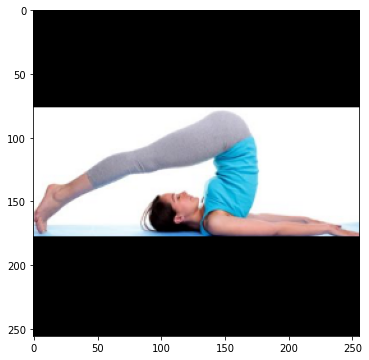

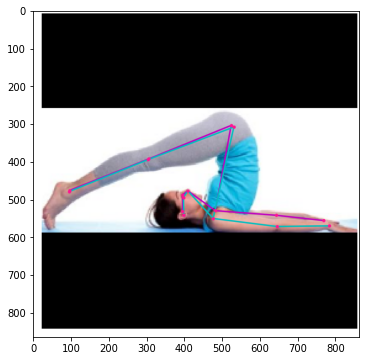

In [ ]:
#Run for single image and plotting the image
image_path = output+'/train/Halasana/File33.png'
#image_path = output+'/train/Padmasana/File43.jpg'
#image_path = output+'/train/Bakasana/File37.png'
#image_path = output+'/train/Vrksasana/File49.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
input_image = np.float32(input_image)[:,:,:,:3]
#print("input_image.shape: {}".format(input_image.shape))

keypoint_with_scores = movenet(input_image)
#print("keypoint_with_scores : {}".format(keypoint_with_scores))
c = keypoint_with_scores.flatten().tolist()
X_test_1 = np.array(c).reshape(1,-1)

display_image = tf.expand_dims(image, axis=0)
print("display_image.shape: {}".format(display_image.shape))
display_image = tf.cast(tf.image.resize_with_pad(display_image, input_size, input_size), dtype=tf.int32)
print("display_image.shape: {}".format(display_image.shape))
plt.figure(figsize=(6, 6))
plt.imshow(display_image[0])
output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)
plt.figure(figsize=(6, 6))
plt.imshow(output_overlay)
#plt.axis('off')

In [ ]:
print(X_test_1)
predictions = grid_search.predict(X_test_1)
predictions

[[0.5570792  0.44966978 0.56496912 0.56615949 0.44019073 0.71511066
  0.57187843 0.44163287 0.74953312 0.63270098 0.44685742 0.75118858
  0.6432994  0.44571531 0.74741888 0.62397277 0.55402285 0.75661206
  0.66023409 0.55022049 0.86674649 0.6345191  0.74895072 0.74351233
  0.6657846  0.73445928 0.84483141 0.65609485 0.89464724 0.65993553
  0.6739409  0.89836466 0.43506792 0.35462639 0.60174435 0.77471691
  0.34998891 0.59979743 0.73012882 0.45796603 0.33120254 0.7384584
  0.46034759 0.32185829 0.54165667 0.57111824 0.07375143 0.63702697
  0.57350552 0.07018309 0.6870113 ]]


array([24])

In [ ]:
df_movenet= pd.read_csv(movenet_csv_out_path)
#df_yolov7 = pd.read_csv(movenet_csv_out_path)

# Pose Detection based on Keypoint outputs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv(movenet_csv_out_path)

df = df.drop('isValid', axis=1)
df = df.drop('y_name', axis=1)

target_col = "y_label"

numerical_col = [col for col in df.columns]
if target_col in numerical_col: 
    numerical_col.remove(target_col)

X=df.drop(target_col, axis=1)
y=df[target_col]
#y = keras.utils.to_categorical(y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify = y)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [ ]:
logisticRegr = LogisticRegression()

solvers = ['newton-cg']
penalty = ['l2']
c_values = [1]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logisticRegr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



# cm = metrics.confusion_matrix(Y_test, predictions)
# plt.figure(figsize=(20,20))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# #all_sample_title = 'Accuracy Score: {0}'.format(score)
# #plt.title(all_sample_title, size = 15);

predictions = grid_search.predict(X_test)
print('\nClassification Report:\n', classification_report(Y_test,predictions))

# roc_auc = roc_auc_score(Y_test,grid_search.predict_proba(X_test),multi_class='ovr')
# print("\nroc_auc (One vs Rest):\n".format(roc_auc))


Best: 0.698731 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.698731 (0.036470) with: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.22      0.25      0.24         8
           2       0.75      0.38      0.50         8
           3       0.64      0.88      0.74         8
           4       0.67      0.50      0.57         8
           5       0.78      0.88      0.82         8
           6       0.60      0.75      0.67         8
           7       1.00      0.88      0.93         8
           8       0.60      0.75      0.67         8
           9       0.62      0.62      0.62         8
          10       1.00      0.75      0.86         8
          11       0.58      0.88      0.70         8
          12       1.00      0.62      0.77         8
          13       1.00      0.38      0.55         8
          14       

## Random Forest

In [ ]:
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# cm = metrics.confusion_matrix(Y_test, predictions)
# plt.figure(figsize=(20,20))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(score)
# plt.title(all_sample_title, size = 15);

predictions = grid_search.predict(X_test)
print('\nClassification Report:\n', classification_report(Y_test,predictions))

# roc_auc = roc_auc_score(Y_test,predictions)
# print("\nroc_auc:\n".format(roc_auc))

Best: 0.810058 using {'max_features': 'log2', 'n_estimators': 1000}
0.719359 (0.045371) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.803667 (0.035400) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.805093 (0.036977) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.712593 (0.032519) with: {'max_features': 'log2', 'n_estimators': 10}
0.793697 (0.034486) with: {'max_features': 'log2', 'n_estimators': 100}
0.810058 (0.031307) with: {'max_features': 'log2', 'n_estimators': 1000}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      0.38      0.55         8
           2       0.57      0.50      0.53         8
           3       0.89      1.00      0.94         8
           4       1.00      0.88      0.93         8
           5       0.78      0.88      0.82         8
           6       0.67      0.50      0.57         8
           7       0.80      1.00      0.8

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier()
n_neighbors = range(1, 3, 5,8,15)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

predictions = grid_search.predict(X_test)
print('\nClassification Report:\n', classification_report(Y_test,predictions))
# roc_auc = roc_auc_score(Y_test,predictions)
# print("\nroc_auc:\n".format(roc_auc))

TypeError: ignored

## XGboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier()
weights = [1, 75, 1000]
# define grid search
grid = dict(scale_pos_weight=weights)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

predictions = grid_search.predict(X_test)
print('\nClassification Report:\n', classification_report(Y_test,predictions))

# roc_auc = roc_auc_score(Y_test,predictions)
# print("\nroc_auc:\n".format(roc_auc))


Best: 0.763124 using {'scale_pos_weight': 1}
0.763124 (0.041339) with: {'scale_pos_weight': 1}
0.763124 (0.041339) with: {'scale_pos_weight': 75}
0.763124 (0.041339) with: {'scale_pos_weight': 1000}

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.38      0.46         8
           2       0.57      0.50      0.53         8
           3       0.73      1.00      0.84         8
           4       0.88      0.88      0.88         8
           5       0.67      0.75      0.71         8
           6       0.56      0.62      0.59         8
           7       0.89      1.00      0.94         8
           8       0.75      0.75      0.75         8
           9       0.56      0.62      0.59         8
          10       0.78      0.88      0.82         8
          11       0.75      0.75      0.75         8
          12       0.86      0.75      0.80         8
          13       

## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

predictions = grid_search.predict(X_test)
print('\nClassification Report:\n', classification_report(Y_test,predictions))

# roc_auc = roc_auc_score(Y_test,predictions)
# print("\nroc_auc:\n".format(roc_auc))

Best: 0.819725 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.777656 (0.049652) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.814733 (0.046323) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.396027 (0.050836) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.777301 (0.050993) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.819725 (0.049214) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.438370 (0.057374) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.736422 (0.040883) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.782346 (0.047819) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.509163 (0.046595) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.403001 (0.040458) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.421231 (0.045809) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.295276 (0.033424) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.048017 (0.005255) with: {'C': 0.01, 'gamma': 'scale', 

## NN

In [ ]:
csv_path = movenet_csv_out_path #@param ["movenet_csv_out_path","posenet_csv_out_path","openpose_csv_out_path","csvs_out_train_path" ] {type:"raw"}
dataframe = pd.read_csv(csv_path)
df_to_process = dataframe.copy()

# Drop the file_name columns as you don't need it during training.
df_to_process.drop(columns=['isValid'], inplace=True)
# Extract the list of class names
classes = df_to_process.pop('y_name').unique()

# Extract the labels
y = df_to_process.pop('y_label')

# Convert the input features and labels into the correct format for training.
X = df_to_process.astype('float64')
y = keras.utils.to_categorical(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.15)

In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  #left = tf.gather(landmarks, left_bodypart.value, axis=1)
  #right = tf.gather(landmarks, right_bodypart.value, axis=1)

  left = tf.gather(landmarks, left_bodypart, axis=1)
  right = tf.gather(landmarks, right_bodypart, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  left_hip_index = 11 #[30,31]
  right_hip_index = 12 #[33,34]

  left_shoulder_index = 5 #[12,13]
  right_shoulder_index = 6 #[15,16]
  # Hips center
  #hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,BodyPart.RIGHT_HIP)
  hips_center = get_center_point(landmarks, left_hip_index ,right_hip_index)

  # Shoulders center
  #shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,BodyPart.RIGHT_SHOULDER)
  shoulders_center = get_center_point(landmarks, left_shoulder_index,right_shoulder_index)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, left_hip_index,right_hip_index)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,[tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0, name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  left_hip_index = 11 #[30,31]
  right_hip_index = 12 #[33,34]
  # Move landmarks so that the pose center becomes (0,0)
  #pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,BodyPart.RIGHT_HIP)
  pose_center = get_center_point(landmarks, left_hip_index,right_hip_index)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
  print(landmarks)

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding


In [ ]:
from keras.layers import LayerNormalization

In [ ]:
inputs = tf.keras.Input(shape=(51))
#layer = keras.layers.Reshape((17, 3))(inputs)
#layer = keras.layers.Flatten()(layer)
embedding = landmarks_to_embedding(inputs)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(embedding)
layer = keras.layers.LayerNormalization()(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dense(256, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(classes), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
print(model.summary())

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopping])

Epoch 1/200
63/63 [==============================] - 2s 10ms/step - loss: 3.3066 - accuracy: 0.0653 - val_loss: 3.0810 - val_accuracy: 0.2614
Epoch 2/200
63/63 [==============================] - 0s 4ms/step - loss: 2.9607 - accuracy: 0.1556 - val_loss: 2.5355 - val_accuracy: 0.3409
Epoch 3/200
63/63 [==============================] - 0s 5ms/step - loss: 2.5730 - accuracy: 0.2480 - val_loss: 2.0777 - val_accuracy: 0.4943
Epoch 4/200
63/63 [==============================] - 0s 5ms/step - loss: 2.2428 - accuracy: 0.3514 - val_loss: 1.8455 - val_accuracy: 0.5227
Epoch 5/200
63/63 [==============================] - 0s 5ms/step - loss: 2.0308 - accuracy: 0.3966 - val_loss: 1.6106 - val_accuracy: 0.5398
Epoch 6/200
63/63 [==============================] - 0s 5ms/step - loss: 1.8283 - accuracy: 0.4488 - val_loss: 1.4284 - val_accuracy: 0.6080
Epoch 7/200
63/63 [==============================] - 0s 5ms/step - loss: 1.7021 - accuracy: 0.4669 - val_loss: 1.3103 - val_accuracy: 0.6250
Epoch 8/200


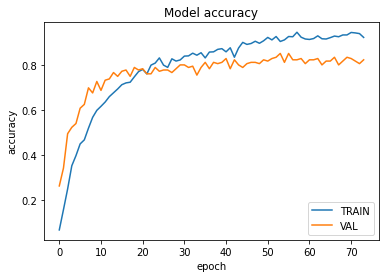

In [ ]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


In [ ]:
y_pred_label = [classes[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [classes[i] for i in Y_test]

In [ ]:
print('\nClassification Report:\n', classification_report(y_true_label,y_pred_label))


Classification Report:
                                precision    recall  f1-score   support

         Adho Mukha Svanasana       0.38      0.62      0.48         8
         Adho Mukha Vrksasana       0.62      1.00      0.76         8
                 Anjaneyasana       0.83      0.62      0.71         8
         Ardha Matsyendrasana       0.80      0.50      0.62         8
              Baddha Konasana       0.50      0.25      0.33         8
                     Bakasana       0.19      0.62      0.29         8
                     Balasana       0.40      0.75      0.52         8
                   Bitilasana       0.19      0.88      0.32         8
                   Garudasana       1.00      0.12      0.22         8
                     Halasana       0.86      0.75      0.80         8
                     Malasana       1.00      0.38      0.55         8
                    Padmasana       0.67      0.75      0.71         8
            Paschimottanasana       1.00      0.73 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
